In [9]:
import keras
from keras import models
from keras.layers import core, convolutional, LSTM, Embedding, Dense, Dropout
from keras.optimizers import SGD, Adam
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
#import cv2
import os
from pprint import pprint
import random
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import Counter

In [3]:
class Game:
    def __init__(self, custom_config=False):
        chrome_options = webdriver.chrome.options.Options()
        chrome_options.add_argument("disable_infobars")
        self.driver = webdriver.Chrome(executable_path="chromedriver", options=chrome_options)
        self.driver.set_window_position(x=-10,y=0)
        self.driver.set_window_size(200, 700)
        self.driver.get("https://play2048.co/")
        self.driver.execute_script("myGM = new GameManager(4, KeyboardInputManager, HTMLActuator, LocalStorageManager);")


    def get_crashed(self):
        return self.driver.execute_script("return myGM.isGameTerminated();")
    def get_board(self):
        grid = self.driver.execute_script("return myGM.grid.cells;")
        #print(grid)
        mygrid = []
        for line in grid:
            a = [x['value'] if x != None else 0 for x in line]
            #a = [1 if x != None else 0 for x in line]
            mygrid.append(a)
        #pprint(mygrid)
        return np.array(mygrid).reshape(1,16)

    def get_score(self):
        return self.driver.execute_script("return myGM.score;")
        #return self.driver.find_element_by_class_name("score-container").text
    def restart(self):
        self.driver.execute_script("myGM.restart();")
    def move(self, direction="up"):
        if direction==0:
            key = Keys.ARROW_UP
        elif direction==1:
            key = Keys.ARROW_DOWN
        elif direction==2:
            key = Keys.ARROW_LEFT
        elif direction==3:
            key = Keys.ARROW_RIGHT
        self.driver.find_element_by_tag_name("body").send_keys(key)
        

In [36]:
def play(game, n=1, slow=False, once=False, restartAfterXMoves=None, with_replay=True, verbose=False):
    scores = []
    game_counter = 0
    prediction = None
    epsilon = 75
    while game_counter < n:
        x_moves = 0
        while not g.get_crashed():
            if slow:
                time.sleep(0.75)
            prev_score = g.get_score()
            old_state = g.get_board()
            
            # exploring randomly some new branches
            if random.randint(0, 200) < epsilon:
                final_move = random.randint(0,3)
            else:
                print(np.shape(old_state))
                prediction = agent.model.predict(old_state)
                predicted_move = np.argmax(prediction)
                final_move = predicted_move
                moveCounter.update([final_move])
            g.move(final_move)
            new_state = g.get_board()
            
            # if no points achieved, give negative reward
            reward = g.get_score() - prev_score -1
            done = g.get_crashed()
            #print(final_move)
            
            
            if done:
                reward = -10
            agent.train_short_memory(old_state, final_move, reward, new_state, done, verbose=verbose)
            agent.remember_long_term(old_state, final_move, reward, new_state, done)
            if verbose:
                print(final_move)
                #print(prediction)
                print(reward)
            if once:
                return
            x_moves += 1
            if restartAfterXMoves and x_moves>=restartAfterXMoves:
                break
        if with_replay:
            agent.replay_new(agent.memory)
        game_counter += 1
        print("Game", game_counter, "\tScore: ", g.get_score())
        scores.append(g.get_score())
        g.restart()
    return scores

In [5]:
class myDQNAgent():
    def __init__(self, game):
        #self.reward = 0
        self.gamma = 0.5
        #self.dataframe = pd.DataFrame()
        self.short_memory = np.array([])
        #self.agent_target = 1
        #self.agent_predict = 0
        self.learning_rate = 0.001
        self.game = game
        #self.model = self.network()
        #self.model = self.network("weights.hdf5")
        self.epsilon = 0
        #self.actual = []
        self.memory = []
        self.model = self.buildmodel()
        
    def buildmodel(self):
        print("building a model")
        model = models.Sequential()
        model.add(Dense(16, activation='relu', input_dim=16))
        #model.add(Dropout(0.15))
        #model.add(Dense(50, activation='relu'))
        #model.add(Dropout(0.15))
        model.add(Dense(20, activation='relu'))
        #model.add(Dropout(0.15))

        #model.add(Dense(30, input_dim=16, activation='relu'))
        #model.add(Dropout(0.15))
        #model.add(Dense(30, activation='relu'))
        #model.add(Dropout(0.15))
        #model.add(Dense(8, activation='relu'))
        #model.add(Dropout(0.15))
        model.add(Dense(4, activation='linear'))
        opt = Adam(lr=self.learning_rate)
        model.compile(loss='mse', optimizer=opt)
        print("model built")
        return model
    
    def remember_long_term(self, state, action, reward, next_state, terminated):
        self.memory.append((state, action, reward, next_state, terminated))
        
    def train_short_memory(self, state, action, reward, next_state, terminated, verbose=False):
        target = reward
        #print(state)
        #print(np.shape(state))
        q = self.model.predict(state)
        qn = self.model.predict(next_state)
        if not terminated:
            target = reward + self.gamma * np.max(qn[0])
        if verbose:
            print(q)
        q[0][action] = target
        if verbose:
            print(q)
        self.model.fit(state, q, epochs=1, verbose=0)
   
    def replay_new(self, memory):
        if len(memory) > 500:
            minibatch = random.sample(memory, 200)
        else:
            minibatch = memory
        for state, action, reward, next_state, terminated in minibatch:
            q = self.model.predict(state)
            qn = self.model.predict(next_state)
            target = reward

            if not terminated:
                target = reward + self.gamma * np.max(qn[0])
            #target_f = self.model.predict(state.reshape((1,16)))
            #print(q)
            #print(target)
            q[0][action] = target
            #t = time.time()
            r = self.model.fit(state, q, epochs=1, verbose=0)
            

In [25]:
g = Game()

In [26]:
agent = myDQNAgent(g)

building a model
model built


In [71]:
moveCounter = Counter()

In [ ]:
s = play(g, n=100, once=False,slow=False, restartAfterXMoves=10, with_replay=True, verbose=True)

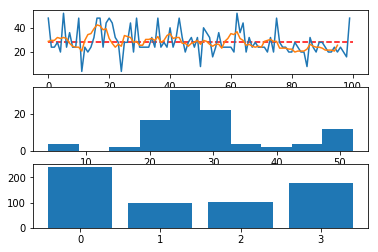

In [73]:
a = np.average(s)
plt.figure(1)
plt.subplot(311)
plt.plot(s)
plt.plot(pd.Series(s).rolling(window=5).mean().iloc[5-1:].values)
plt.hlines(a, 0, len(s), colors='r', linestyles="dashed")
plt.subplot(312)
plt.hist(s, bins=10)
plt.subplot(313)
plt.bar(list(moveCounter.keys()), list(moveCounter.values()))
plt.xticks(list(moveCounter.keys()))
plt.show()

In [ ]:
old_state = g.get_board()
prediction = agent.model.predict(old_state.reshape(1,16))
print(prediction)

In [ ]:
for i in agent.memory:
    if np.array_equal(i[0], old_state):
        print(i)

In [ ]:
q = np.array([[0, 0, 1, 1]], dtype="float32")

In [ ]:
h = agent.model.fit(b, q, epochs=1, verbose=1)

In [ ]:
b = g.get_board().reshape(1,16)
agent.model.predict(b)

In [74]:
b = np.array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]).reshape(1,16)
agent.model.predict(b)

array([[17.173529, 14.469221, 17.179583, 17.521086]], dtype=float32)

In [75]:
b = np.zeros(16).reshape(1,16)
agent.model.predict(b)

array([[0.8242398 , 0.8183702 , 1.0555861 , 0.84866697]], dtype=float32)

In [ ]:
pprint(agent.memory)

In [ ]:
agent.model.optimizer.get_weights()

In [ ]:
s_ver

In [ ]:
s_hor

In [ ]:
for i in range(1000):
    agent.model.fit(s_hor.reshape(1, 16), np.array([[-1, -1, 1, 1]], dtype="float32"))
    agent.model.fit(s_ver.reshape(1, 16), np.array([[1, 1, -1, -1]]))

In [ ]:
agent.model.predict(s_hor.reshape(1,16))

In [ ]:
agent.model.predict(s_ver.reshape(1,16))

In [ ]:
old_state=old_state.reshape((16))

In [ ]:
print(old_state)

In [ ]:
np.shape(old_state)